In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 

import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, LinearRegression

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp 
from jax import jit, vmap, grad
from jax.nn import sigmoid

In [2]:
# from jax.config import config; config.update("jax_enable_x64", True)

In [4]:
EPS = 1e-10
fontsize=13

In [5]:
import sys
sys.path.append('../')
import adaprobe

# Simulation

In [351]:
100/125

0.8

In [563]:
N = 40
K = 30
powers = np.arange(5, 31, 10)
phi_1 = np.random.uniform(2.5, 5.5, N)
a = 0.3
sigma = 3

sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)

In [564]:
num_targets = 16

In [565]:
# sim.simulate(trials=K, powers=powers)
sim.simulate_multistim(trials=K, num_targets=num_targets, powers=powers)

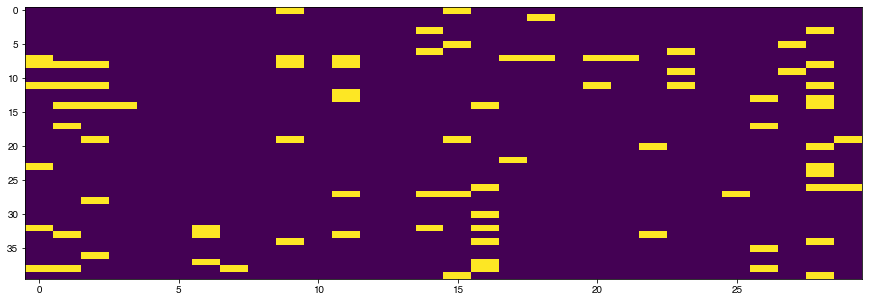

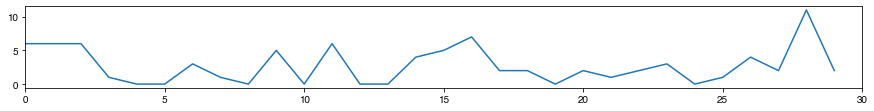

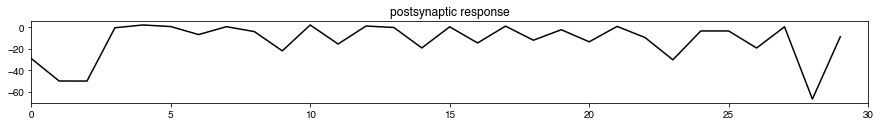

In [566]:
plt.figure(figsize=(15, 5))
plt.imshow(sim.spks, aspect='auto', interpolation='nearest')
plt.show()

plt.figure(figsize=(15, 1.5))
plt.plot(np.sum(sim.spks, 0))
plt.xlim([0, K])
plt.show()

plt.figure(figsize=(15, 1.5))
plt.title('postsynaptic response')
plt.plot(sim.y, color='k')
plt.xlim([0, K])
plt.show()

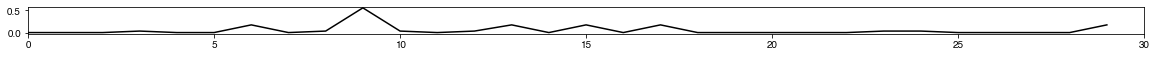

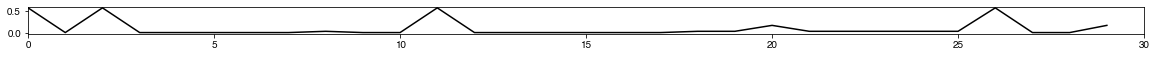

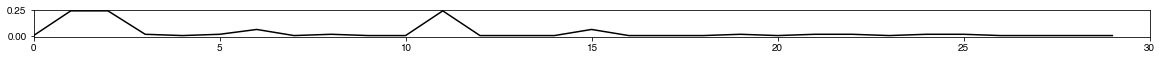

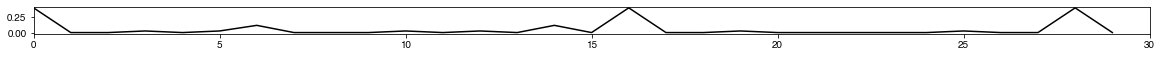

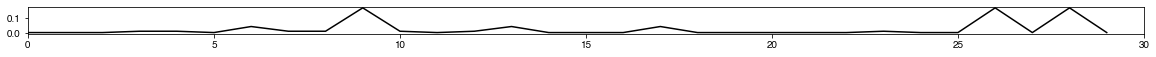

In [567]:
for n in range(5):
    plt.figure(figsize=(20, 0.5))
    plt.plot(sim.fr[n], color='k')
    plt.xlim([0, K])
    plt.show()

In [568]:
stim = np.zeros((N, K))
for n in range(N):
    locs = np.where(sim.tars == n)[0]
    stim[n, locs] = sim.I[locs]

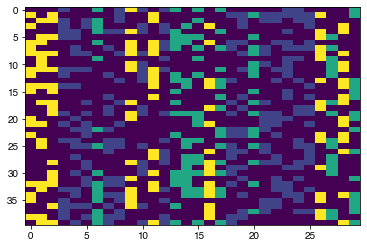

In [569]:
plt.imshow(stim[:, :100], aspect='auto', interpolation='nearest')

In [570]:
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])

# Single model fit

In [571]:
fit_options_mbcs = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'penalty': 5,
    'max_penalty_iters': 15,
    'lam_masking': False,
    'scale_factor': 0.65,
    'warm_start_lasso': False,
    'constrain_weights': True,
    'verbose': False,
}

fit_options_vsns = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'lam_masking': False,
    'learn_noise': False
}

priors = {
    'alpha': 0.15 * np.ones(N),
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior,
    'rate': sigma**2.,
    'shape': 1.
}

model_mbcs = adaprobe.Model(N, model_type='mbcs', priors=priors)
model_vsns = adaprobe.Model(N, model_type='variational_sns', priors=priors)

In [572]:
%time model_vsns.fit(sim.y, stim, method='cavi_sns', fit_options=fit_options_vsns)

CPU times: user 4.21 s, sys: 1.11 s, total: 5.31 s
Wall time: 5.31 s


In [573]:
%time model_mbcs.fit(sim.y, stim, method='mbcs', fit_options=fit_options_mbcs)

CPU times: user 7.09 s, sys: 1.25 s, total: 8.34 s
Wall time: 7.62 s


In [574]:
tar_matrix = (stim > 0).astype(float)
%time w_cosamp = adaprobe.optimise.cosamp(tar_matrix.T, sim.y, np.sum(sim.w != 0))

CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 328 ms


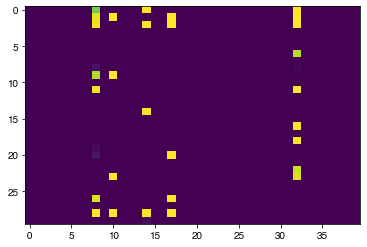

In [575]:
plt.imshow(model_mbcs.state['lam'], aspect='auto', interpolation='nearest')

In [576]:
lam = model_mbcs.state['lam']

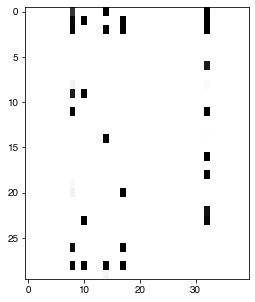

In [577]:
plt.figure(figsize=(4, 5))
plt.imshow(lam, aspect='auto', cmap='gray_r')
plt.show()

In [578]:
ordr = np.random.choice(N, N, replace=False)

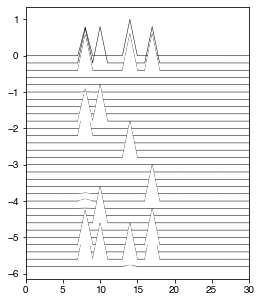

In [579]:
delta = 0.2
plt.figure(figsize=(4, 5))
for k in range(K):
    linestyle = '-' if model_mbcs.state['mu'][ordr[k]] != 0 else '-'
    plt.plot(lam[k] - delta*k, linestyle, color='k', linewidth=0.5)
    
    plt.fill_between(np.arange(N), -delta*k, lam[k] - delta*k, facecolor='white', edgecolor='None', zorder=k+1)
#     locs = np.where(lam[n] >= 0.5)[0]
#     plt.scatter(locs, np.ones(len(locs)) - delta*n, 40, edgecolor='red', linewidth=2, facecolor='white', marker='v', zorder=10)
# plt.axis('off')
plt.xlim([0, K])
# plt.savefig('inferred_spikes_cartoon_vertical.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [580]:
ordr = np.random.choice(N, N, replace=False)

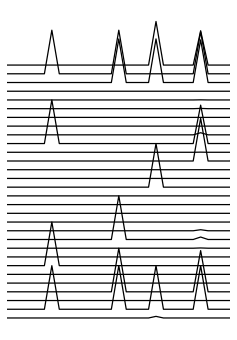

In [581]:
delta = 0.2
plt.figure(figsize=(4, 6))
for k in range(K):
    plt.plot(lam[k, ordr] - delta*k, '-', color='k', alpha=1, linewidth=1.25)
plt.axis('off')
plt.xlim([0, K])
# plt.savefig('inferred_spikes_cartoon_vertical_dark.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

In [582]:
K

30

In [583]:
N

40

In [584]:
lam.shape

(30, 40)

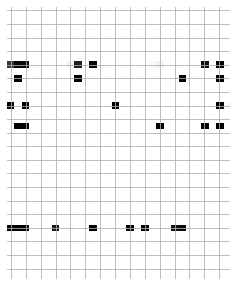

In [585]:
plt.figure(figsize=(4, 5))
plt.imshow(lam.T, cmap='gray_r', aspect='auto', interpolation='nearest')
plt.grid('-')
plt.xticks(range(0, K, 2))
plt.yticks(range(0, N, 2))
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
for loc in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[loc].set_visible(False)
    
# plt.savefig('inferred_spikes_vertical_dense_grid.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [606]:
plt.figure(figsize=(0.2, 4))
plt.imshow(sim.w[:, None], cmap='gray', aspect='auto', interpolation='nearest')
# plt.axis('off')
plt.xticks([])
plt.yticks([])
# plt.savefig('connectivity_vector.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [612]:
plt.figure(figsize=(0.2, 2))
plt.imshow(sim.y[:20, None], cmap='gray', aspect='auto', interpolation='nearest')
# plt.axis('off')
plt.xticks([])
plt.yticks([])
# plt.savefig('measurement_vector.pdf', format='pdf', bbox_inches='tight')
plt.show()

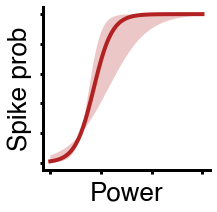

In [639]:
phi = model_mbcs.state['phi']
phi_cov = model_mbcs.state['phi_cov']
phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
plow = phi - 2*phi_sdevs
phigh = phi + 2*phi_sdevs

phi_true = np.c_[sim.phi_0, sim.phi_1]

Irng = np.arange(0, 61)

N_sample = 20

ncols = 5
nrows = int(np.ceil(N_sample/ncols))
panel_size = 2.5
plt.figure(figsize=(3, 3))
n = 10

# plt.plot(sigmoid(phi_true[n, 0] * Irng - phi_true[n, 1]), linestyle=linestyle, color=true_col)
plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color='firebrick', linewidth=4)
plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), 
                 facecolor='firebrick', edgecolor='None', alpha=0.25)

for loc in ['top', 'right']:
    plt.gca().spines[loc].set_visible(False)
for loc in ['left', 'bottom']:
    plt.gca().spines[loc].set_linewidth(3)
    
plt.gca().xaxis.set_tick_params(width=3)
plt.gca().yaxis.set_tick_params(width=3)

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
    
plt.xlabel('Power', fontsize=26)
plt.ylabel('Spike prob', fontsize=26)

# plt.savefig('receptive_field_cartoon.pdf', format='pdf', bbox_inches='tight')

plt.show()

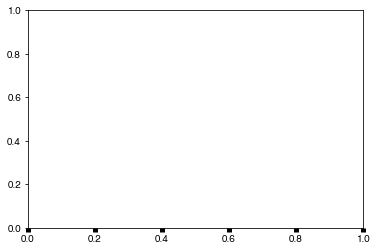

/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/numpy/ma/core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: x and y must be the same size

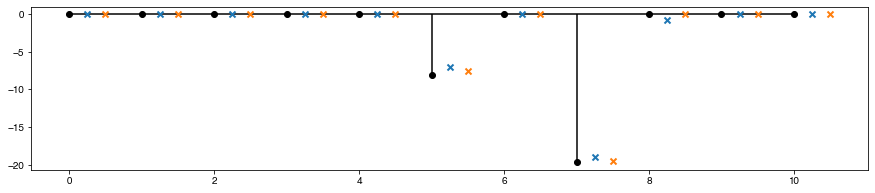

In [116]:
fontsize=14

rng = np.arange(N)
model_offset = 0.25

cols = ['firebrick', 'C1']

plt.figure(figsize=(15, 3))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
plt.scatter(rng + model_offset, model_mbcs.state['mu'], marker='x', color='C0', label='MBCS', zorder=10, linewidth=2)
plt.scatter(rng + 2 * model_offset, model_vsns.state['mu'] * model_vsns.state['alpha'], marker='x', color='C1', label='VSNS', zorder=11, linewidth=2)
plt.scatter(rng + 3 * model_offset, w_cosamp, marker='x', color='C2', label='CoSaMP (true sparsity)', zorder=11, linewidth=2)

# plt.errorbar(rng + model_offset + 0.03, model_mbcs.state['mu'], yerr = model_mbcs.state['beta'], fmt='.', color='C0')

plt.xlim([-1, N+1])
plt.ylim(bottom=-30)
plt.legend(ncol=4, fontsize=14, loc='lower right', frameon=True)
# plt.ylim(top=4)
plt.xlabel('Neurons', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Synaptic strength', fontsize=fontsize)
plt.title('Undersampled (%i trials, %i targets)'%(K, num_targets), fontsize=fontsize)
# plt.savefig('figs/model_based_cs/mbcs_vs_vsns_vs_cosamp_single_trial_comparison_noise_known_undersampled_N%i_a%.2f_sig%.2f.pdf'%(N, a, sigma), format='pdf', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
print('true noise', sigma)
print('est. noise', np.sqrt(model_vsns.state['rate']/model_vsns.state['shape']))

In [ ]:
plt.figure(figsize=(3, 3))
plt.scatter(sim.w, model_vsns.state['mu'], color='C1', label='VarSNS')
plt.scatter(sim.w, model_mbcs.state['mu'], color='C0', label='MBCS')
plt.scatter(sim.w, w_cosamp, color='C2', label='CS')
# plt.legend(fontsize=fontsize)
plt.plot([-21, 5], [-21, 5], 'k--')
plt.xlabel('True weights', fontsize=fontsize)
plt.ylabel('Inferred weights', fontsize=fontsize)
plt.xticks(np.arange(-20, 6, 5), fontsize=fontsize)
plt.yticks(np.arange(-20, 6, 5), fontsize=fontsize)
plt.grid(linestyle='--')
# plt.title('Undersampled', fontsize=fontsize)
plt.show()

In [ ]:
print(r2_score(sim.w, w_cosamp))
print(r2_score(sim.w, model_mbcs.state['mu']))
print(r2_score(sim.w, model_vsns.state['mu'] * model_vsns.state['alpha']))

In [ ]:
def get_r2_history(sim, model):
    return [r2_score(sim.w, model.history['mu'][it]) for it in range(model.history['mu'].shape[0])]
def get_err_history(sim, model):
    return [np.mean(np.square(sim.w - model.history['mu'][it])) for it in range(model.history['mu'].shape[0])]

In [ ]:
linewidth=1.5
markeredgewidth=1.5

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(get_r2_history(sim, model_mbcs), 'o-', fillstyle='none', label='MBCS', markeredgewidth=markeredgewidth, linewidth=linewidth)
plt.plot(get_r2_history(sim, model_vsns), '^-', fillstyle='none', label='VarSNS', markeredgewidth=markeredgewidth, linewidth=linewidth)
plt.ylabel('$R^2$', fontsize=fontsize)
plt.grid(linestyle='--')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('CAVI iteration', fontsize=fontsize)
plt.ylim(top=1)
plt.ylim(bottom=0)
# plt.yscale('log')
plt.legend(fontsize=fontsize)

plt.subplot(1, 2, 2)
plt.plot(get_err_history(sim, model_mbcs), 'o-', fillstyle='none', label='MBCS', markeredgewidth=markeredgewidth, linewidth=linewidth)
plt.plot(get_err_history(sim, model_vsns), '^-', fillstyle='none', label='VarSNS', markeredgewidth=markeredgewidth, linewidth=linewidth)
plt.ylabel('MSE', fontsize=fontsize)
plt.grid(linestyle='--')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('CAVI iteration', fontsize=fontsize)
plt.ylim(bottom=0)

plt.show()

In [ ]:
# penalty constraint
print('err', np.sqrt(np.sum(np.square(sim.y - model_mbcs.state['lam'] @ model_mbcs.state['mu']))))
print('constr', np.sqrt(np.sum(np.square(sim.y - sim.spks.T @ sim.w))))

In [ ]:
# oversampled case
model_mbcs_os = adaprobe.Model(N, model_type='mbcs', priors=priors)
model_vsns_os = adaprobe.Model(N, model_type='variational_sns', priors=priors)

In [ ]:
K_os = 2000

In [ ]:
sim.reset()
sim.simulate_multistim(trials=K_os, num_targets=num_targets, powers=powers)

In [ ]:
stim = np.zeros((N, K_os))
for n in range(N):
    locs = np.where(sim.tars == n)[0]
    stim[n, locs] = sim.I[locs]

In [ ]:
%time model_vsns_os.fit(sim.y, stim, method='cavi_sns', fit_options=fit_options_vsns)

In [ ]:
%time model_mbcs_os.fit(sim.y, stim, method='mbcs', fit_options=fit_options_mbcs)

In [ ]:
tar_matrix = (stim > 0).astype(float)
%time w_cosamp_os = adaprobe.optimise.cosamp(tar_matrix.T, sim.y, np.sum(sim.w != 0))

In [ ]:
fontsize=14

rng = np.arange(N)
model_offset = 0.15

cols = ['firebrick', 'C1']

plt.figure(figsize=(15, 3))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
plt.scatter(rng + model_offset, model_mbcs_os.state['mu'], marker='x', color='C0', label='MBCS', zorder=10, linewidth=2)
plt.scatter(rng + 2 * model_offset, model_vsns_os.state['mu'] * model_vsns_os.state['alpha'], marker='x', color='C1', label='VSNS', zorder=11, linewidth=2)
plt.scatter(rng + 2 * model_offset, w_cosamp_os, marker='x', color='C2', label='CoSaMP (true sparsity)', zorder=11, linewidth=2)

plt.xlim([-1, N+1])
plt.ylim(bottom=-30)
plt.legend(ncol=4, fontsize=14, loc='lower right', frameon=True)
plt.xlabel('Neurons', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Synaptic strength', fontsize=fontsize)
plt.title('Oversampled (%i trials, %i targets)'%(K_os, num_targets), fontsize=fontsize)
# plt.savefig('figs/model_based_cs/mbcs_vs_vsns_vs_cosamp_single_trial_comparison_noise_known_oversampled_N%i_a%.2f_sig%.2f.pdf'%(N, a, sigma), format='pdf', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.figure(figsize=(7, 3.5))
plt.subplot(1, 2, 1)
plt.scatter(sim.w, model_mbcs.state['mu'], color='C0', label='MBCS')
plt.scatter(sim.w, model_vsns.state['mu'], color='C1', label='VarSNS', alpha=0.5)
plt.scatter(sim.w, w_cosamp, edgecolor='C2', facecolor='None', label='CoSaMP')
plt.legend(fontsize=fontsize)
plt.plot([-25, 5], [-25, 5], 'k--')
plt.xlabel('True weights', fontsize=fontsize)
plt.ylabel('Inferred weights', fontsize=fontsize)
plt.xticks(np.arange(-25, 6, 5), fontsize=fontsize)
plt.yticks(np.arange(-25, 6, 5), fontsize=fontsize)
plt.xlim([-26, 6])
plt.ylim([-26, 6])
plt.grid(linestyle='--')
plt.title('Undersampled', fontsize=fontsize)
plt.text(-25, 2.5, '%.2f'%r2_score(sim.w, model_mbcs.state['mu']), fontsize=fontsize, color='C0', weight='bold')
plt.text(-19, 2.5, '%.2f'%r2_score(sim.w, model_vsns.state['mu'] * model_vsns.state['alpha']), fontsize=fontsize, color='C1')
plt.text(-13, 2.5, '%.2f'%r2_score(sim.w, w_cosamp), fontsize=fontsize, color='C2')

plt.subplot(1, 2, 2)
plt.scatter(sim.w, model_mbcs_os.state['mu'], color='C0', label='MBCS')
plt.scatter(sim.w, model_vsns_os.state['mu'], color='C1', label='VarSNS', alpha=0.5)
plt.scatter(sim.w, w_cosamp_os, facecolor='None', edgecolor='C2')
# plt.legend(fontsize=fontsize)
plt.plot([-25, 5], [-25, 5], 'k--')
plt.xlabel('True weights', fontsize=fontsize)
# plt.ylabel('Inferred weights', fontsize=fontsize)
plt.xticks(np.arange(-25, 6, 5), fontsize=fontsize)
plt.yticks(np.arange(-25, 6, 5), fontsize=fontsize)
plt.grid(linestyle='--')
plt.title('Oversampled', fontsize=fontsize)
plt.text(-25, 2.5, '%.2f'%r2_score(sim.w, model_mbcs_os.state['mu']), fontsize=fontsize, color='C0')
plt.text(-19, 2.5, '%.2f'%r2_score(sim.w, model_vsns_os.state['mu'] * model_vsns_os.state['alpha']), fontsize=fontsize, color='C1')
plt.text(-13, 2.5, '%.2f'%r2_score(sim.w, w_cosamp_os), color='C2', fontsize=fontsize)
plt.tight_layout()
# plt.savefig('figs/model_based_cs/mbcs_vs_vsns_vs_cosamp_single_trial_comparison_noise_known_undersampeld_vs_oversampled_N%i_a%.2f_sig%.2f.pdf'%(N, a, sigma), format='pdf', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

# Performance comparison across population sizes

In [ ]:
def get_r2_history(sim, model):
    return [r2_score(sim.w, model.history['mu'][it]) for it in range(model.history['mu'].shape[0])]
def get_err_history(sim, model):
    return [np.mean(np.square(sim.w - model.history['mu'][it])) for it in range(model.history['mu'].shape[0])]

In [ ]:
N = 1000
powers = np.arange(20, 51, 10)
phi_1 = np.random.uniform(2.5, 5.5, N)
a = 0.05
sigma = 3

Ks = [500, 2000]
ntars = [16, 32, 64]

num_conditions = len(Ks) * len(ntars)

In [ ]:
fit_options_mbcs = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'penalty': 5,
    'max_penalty_iters': 15,
    'lam_masking': False,
    'scale_factor': 0.65,
    'warm_start_lasso': False,
    'constrain_weights': True,
    'verbose': False,
}

fit_options_vsns = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'lam_masking': False,
    'learn_noise': False
}

priors = {
    'alpha': 0.5 * np.ones(N),
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'rate': sigma**2.,
    'shape': 1.
}

model_mbcs = [[adaprobe.Model(N, model_type='mbcs', priors=priors) for _ in range(len(ntars))] for _ in range(len(Ks))]
model_vsns = [[adaprobe.Model(N, model_type='variational_sns', priors=priors) for _ in range(len(ntars))] for _ in range(len(Ks))]
sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)

In [ ]:
adaprobe.optimise.cosamp

In [ ]:
for kindx, K in enumerate(Ks):
    for tindx, tars in enumerate(ntars):
        print('sim K:%i ntars:%i'%(K, tars))
        sim.reset()
        model_mbcs[kindx][tindx].reset()
        model_vsns[kindx][tindx].reset()
        
        sim.simulate_multistim(trials=K, num_targets=tars, powers=powers)
        design = np.zeros((N, K))
        for n in range(N):
            locs = np.where(sim.tars == n)[0]
            design[n, locs] = sim.I[locs]
        %time model_mbcs[kindx][tindx].fit(sim.y, design, method='mbcs', fit_options=fit_options_mbcs)
        %time model_vsns[kindx][tindx].fit(sim.y, design, method='cavi_sns', fit_options=fit_options_vsns)
        print()


In [ ]:
linewidth=1.5
markeredgewidth=1.5

cm = 1/2.54
panel_size = 2.5
nrows = len(ntars)
ncols = len(Ks)

plot_cntr = 1

plt.figure(figsize=(panel_size * ncols, panel_size * nrows))
for tindx, tars in enumerate(ntars):
    for kindx, K in enumerate(Ks):
        plt.subplot(nrows, ncols, plot_cntr)
        plt.plot(get_r2_history(sim, model_mbcs[kindx][tindx]), 'o-', fillstyle='none', label='MBCS', markeredgewidth=markeredgewidth, linewidth=linewidth)
        plt.plot(get_r2_history(sim, model_vsns[kindx][tindx]), '^-', fillstyle='none', label='VarSNS', markeredgewidth=markeredgewidth, linewidth=linewidth)
        plt.grid(linestyle='--')
        if kindx == 1:
            plt.gca().set_yticklabels([])
        plt.xticks(np.arange(0, 51, 10), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        if tindx == len(ntars) - 1:
            plt.xlabel('CAVI iteration', fontsize=fontsize)
        else:
            plt.gca().set_xticklabels([])
        if plot_cntr == 6:
            plt.legend(fontsize=fontsize, title='synaptic\nweight $R^2$', title_fontsize=fontsize, frameon=False, loc='lower right')
        plot_cntr += 1
        plt.ylim(top=1)
        plt.ylim(bottom=0)
        if tindx == 0:
            plt.title('%i trials'%K, fontsize=fontsize)
        if kindx == 0:
            plt.ylabel('%i targets'%tars, fontsize=fontsize)
plt.suptitle('Population size: %i\nConnection probability: %.2f'%(N, a), fontsize=fontsize)
plt.tight_layout()
# plt.savefig('figs/model_based_cs/mbcs_penalty_shrinkage_vs_vsns_N%i_a%.2f_example_3.pdf'%(N, a), format='pdf', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()

# Performance comparison across synapse sparsity

In [ ]:
N = 200
powers = np.arange(20, 51, 10)
phi_1 = np.random.uniform(2.5, 5.5, N)
sigma = 3

ntars = [4, 16, 32]
_as = [0.05, 0.1, 0.25]
Ks = [150, 500]

num_conditions = len(Ks) * len(ntars)

In [ ]:
a = _as[2]

In [ ]:
fit_options_mbcs = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'penalty': 5,
    'max_penalty_iters': 15,
    'lam_masking': False,
    'scale_factor': 0.65,
    'warm_start_lasso': False,
    'constrain_weights': True,
    'verbose': False,
}

fit_options_vsns = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'lam_masking': False,
    'learn_noise': False
}

priors = {
    'alpha': 0.5 * np.ones(N),
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'rate': sigma**2.,
    'shape': 1.
}

model_mbcs = [[adaprobe.Model(N, model_type='mbcs', priors=priors) for _ in range(len(ntars))] for _ in range(len(Ks))]
model_vsns = [[adaprobe.Model(N, model_type='variational_sns', priors=priors) for _ in range(len(ntars))] for _ in range(len(Ks))]
sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)

In [ ]:
for kindx, K in enumerate(Ks):
    for tindx, tars in enumerate(ntars):
        print('sim K:%i ntars:%i'%(K, tars))
        sim.reset()
        model_mbcs[kindx][tindx].reset()
        model_vsns[kindx][tindx].reset()
        
        sim.simulate_multistim(trials=K, num_targets=tars, powers=powers)
        design = np.zeros((N, K))
        for n in range(N):
            locs = np.where(sim.tars == n)[0]
            design[n, locs] = sim.I[locs]
        %time model_mbcs[kindx][tindx].fit(sim.y, design, method='mbcs', fit_options=fit_options_mbcs)
        %time model_vsns[kindx][tindx].fit(sim.y, design, method='cavi_sns', fit_options=fit_options_vsns)
        print()


In [ ]:
linewidth=1.5
markeredgewidth=1.5

cm = 1/2.54
panel_size = 2.5
nrows = len(ntars)
ncols = len(Ks)

plot_cntr = 1

plt.figure(figsize=(panel_size * ncols, panel_size * nrows))
for tindx, tars in enumerate(ntars):
    for kindx, K in enumerate(Ks):
        plt.subplot(nrows, ncols, plot_cntr)
        plt.plot(get_r2_history(sim, model_mbcs[kindx][tindx]), 'o-', fillstyle='none', label='MBCS', markeredgewidth=markeredgewidth, linewidth=linewidth)
        plt.plot(get_r2_history(sim, model_vsns[kindx][tindx]), '^-', fillstyle='none', label='VarSNS', markeredgewidth=markeredgewidth, linewidth=linewidth)
        plt.grid(linestyle='--')
        if kindx == 1:
            plt.gca().set_yticklabels([])
        plt.xticks(np.arange(0, 51, 10), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        if tindx == len(ntars) - 1:
            plt.xlabel('CAVI iteration', fontsize=fontsize)
        else:
            plt.gca().set_xticklabels([])
        if plot_cntr == 6:
            plt.legend(fontsize=fontsize, title='synaptic\nweight $R^2$', title_fontsize=fontsize, frameon=False, loc='lower right')
        plot_cntr += 1
        plt.ylim(top=1)
        plt.ylim(bottom=0)
        if tindx == 0:
            plt.title('%i trials'%K, fontsize=fontsize)
        if kindx == 0:
            plt.ylabel('%i targets'%tars, fontsize=fontsize)
plt.suptitle('Population size: %i\nConnection probability: %.2f'%(N, a), fontsize=fontsize)
plt.tight_layout()
# plt.savefig('figs/model_based_cs/mbcs_penalty_shrinkage_vs_vsns_vary_connection_prob_N%i_a%.2f_example_3.pdf'%(N, a), format='pdf', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()

# Comparing LASSO with vs without spike-and-slab

In [ ]:
pen = 1e-1

fit_options_with_alpha = {
    'iters': 100,
    'num_mc_samples': 5,
    'seed': 0,
    'penalty': pen,
    'learn_alpha': True,
    'lam_masking': False
}

fit_options_wo_alpha = { 
    'iters': 100,
    'num_mc_samples': 5,
    'seed': 0,
    'penalty': pen,
    'learn_alpha': False,
    'lam_masking': False
}

fit_options = [fit_options_with_alpha, fit_options_wo_alpha]

priors_with_alpha = {
    'alpha': 0.25 * np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

priors_without_alpha = {
    'alpha': np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

priors = [priors_with_alpha, priors_without_alpha]


models = [adaprobe.Model(sim.cell_locs, priors=priors[i]) for i in range(2)]

In [ ]:
# model.reset()

In [ ]:
for i in range(2):
    %time models[i].fit(sim.y, stim, fit_options=fit_options[i])#, method='cavi_offline_spike_and_slab_NOTS_jax')

In [ ]:
bin_stimulus_matrix = stim.copy()
bin_stimulus_matrix[stim > 0] = 1

sparse_lasso = Lasso(alpha=0.02, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

In [ ]:
%time sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

In [ ]:
fontsize=14

w_est = [models[i].state['mu'] * models[i].state['alpha'] for i in range(2)]

rng = np.arange(N)
model_offset = 0.25

cols = ['firebrick', 'C1']
labels = ['Model with SnS', 'Model w/o SnS']

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
for i in range(2):
    plt.scatter(rng + (i + 1) * model_offset, w_est[i], marker='x', color=cols[i], label=labels[i])
    plt.errorbar(rng + (i + 1) * model_offset + 0.03, w_est[i], yerr = models[i].state['beta'] * (models[i].state['alpha'] >= 0.5), fmt='.', color=cols[i])
plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')
plt.xlim([-1, N+1])
plt.legend(ncol=4, fontsize=14, loc='lower right')
# plt.ylim(top=4)
plt.xlabel('Neurons', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Synaptic strength', fontsize=fontsize)
# plt.savefig('figs/model_based_cs/model_vs_l1_comparison_N%i_a%.2f_sig%.2f_example_wo_sns.png'%(N, a, sigma), format='png', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
np.sqrt(models[1].state['rate']/models[0].state['shape'])

In [ ]:
newl = Lasso(alpha=pen, fit_intercept=False, max_iter=100)

In [ ]:
def myfunc():
    constr = sigma * np.sqrt(K)
    next_pen = 1e0
    scale_factor = 0.65
    max_iters = 10
    pens = np.zeros(max_iters)
    errs = np.zeros(max_iters)
    warm_start = False
    coef = np.zeros(N)
    for it in range(max_iters):
        pen = next_pen
        sparse_lasso = Lasso(alpha=pen, fit_intercept=False, max_iter=100, warm_start=warm_start)
        sparse_lasso.coef_ = coef
        coef = sparse_lasso.fit(bin_stimulus_matrix.T, sim.y).coef_
        warm_start = True
        errs[it] = np.sqrt(np.sum(np.square(sim.y - bin_stimulus_matrix.T @ coef)))
        pens[it] = pen
        next_pen = pen * scale_factor
        if errs[it] < constr:
            break
    return errs, pens

In [ ]:
%time errs, pens = myfunc()

In [ ]:
plt.figure()
plt.plot(errs)
# plt.plot([0, max_iters-1], [constr, constr], 'k--')
plt.show()

plt.figure()
plt.plot(pens)
plt.show()

In [ ]:
sparse_lasso.alpha = 0.01

In [ ]:
sparse_lasso

In [ ]:
sparse_lasso.warm_start = True

In [ ]:
np.corrcoef(w_est[0], sim.w)

In [ ]:
np.corrcoef(w_est[1], sim.w)

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def truncnorm_logpdf(x, loc, scale):
    return np.log(1/scale) + stats.norm.logpdf((x - loc)/scale) - np.log(1 - ndtr(-loc/scale))

In [ ]:
# model = models[1]

In [ ]:
# model.reset()

In [ ]:
# model.fit(np.array(sim.y), stim_online, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

In [ ]:
xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def plot_connections(model, sim, legend=[]):    
    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)
    plt.figure(figsize=(15, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        plt.plot(xrange, post[n], color='firebrick')
        true_col = 'gray' if sim.w[n] == 0 else 'black'
        plt.plot([sim.w[n], sim.w[n]], [0, postmax], '--', color=true_col)
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.xlabel('Synaptic strength')
            plt.ylabel('Probability density')
        if n == 0 and legend is not None:
            plt.legend(legend, loc='upper left', frameon=False)
    plt.show()

plot_connections(models[1], sim)

In [ ]:
plt.plot(model.history['alpha'])
plt.show()

In [ ]:
print(np.round(model.state['mu'], 2))
print(np.round(sim.w, 2))

In [ ]:
def plot_spike_pred(model, sim, xlim=None):
#     spks = np.array(sim.spks).astype(float) # true simulated spikes
#     fr = np.array(sim.fr).T # true simulated firing rates
    lam = np.array(model.state['lam']).T # inferred firing rate
    spks = sim.spks
    fr = sim.fr
    print(spks.shape)
    s_pred = (lam >= 0.5).astype(float) # spike prediction
    for n in range(N):
        plt.figure(figsize=(25, 0.75))
        if sim.w[n] == 0:
            plt.plot(fr[n], color='gray') # disconnected cell
        else:
            plt.plot(fr[n], color='k') # connected cell
        plt.plot(lam[n], '--', color='r')
        plt.scatter(np.arange(len(spks[n])), spks[n], color='gray')
        plt.scatter(np.arange(s_pred[0].shape[0]), s_pred[n], 50, marker='x', color='r')
        if xlim is not None:
            plt.xlim(xlim)
        else:
            plt.xlim([0, lam.shape[-1]])
        plt.ylim([0, 1.1])
        plt.show()

In [ ]:
plot_spike_pred(models[1], sim)

In [ ]:
model.state['mu']

In [ ]:
alpha = model.state['alpha']
w_est = model.state['mu'] * alpha
beta = model.state['beta']

In [ ]:
bin_stimulus_matrix = stim.copy()
bin_stimulus_matrix[stim > 0] = 1

In [ ]:
sparse_lasso = Lasso(alpha=1e-1, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

In [ ]:
rng = np.arange(N)
model_offset = 0.25

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
plt.scatter(rng + model_offset, w_est, marker='x', color='firebrick', label='Model')
plt.errorbar(rng + model_offset + 0.03, w_est, yerr= beta * (alpha >= 0.5), fmt='.', color='firebrick')
plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')
plt.xlim([-1, N+1])

plt.ylim(top=4, bottom=-23)

In [ ]:
locs = np.where(w_est < 0)[0]

In [ ]:
np.corrcoef(sim.w[locs], w_est[locs])[0, 1]

In [ ]:
np.corrcoef(sim.w, sparse_lasso.coef_)[0, 1]

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(sim.w, w_est)
plt.scatter(sim.w, sparse_lasso.coef_)
plt.xlim([-21, 1])
plt.ylim([-21, 1])
plt.xlabel('true')
plt.ylabel('lasso')
plt.show()

In [ ]:
def get_gauss_fn(mu, sig):
    def func(x):
        return 1/np.sqrt(2 * np.pi * sig**2) * np.exp(-(x - mu)**2/(2 * sig**2))
    return func

In [ ]:
phi = models[1].state['phi']
phi_cov = models[1].state['phi_cov']
phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
plow = phi - phi_sdevs
phigh = phi + phi_sdevs

phi_true = np.c_[sim.phi_0, sim.phi_1]

Irng = np.arange(0, 61)

N_sample = 20

ncols = 5
nrows = int(np.ceil(N_sample/ncols))
panel_size = 2.5
plt.figure(figsize=(ncols * panel_size, nrows * panel_size))
for n in range(N_sample):
    plt.subplot(nrows, ncols, n + 1)
    if sim.z[n]:
        true_col = 'k'
        linestyle='-'
    else:
        true_col = 'gray'
        linestyle='--'
    plt.plot(sigmoid(phi_true[n, 0] * Irng - phi_true[n, 1]), linestyle=linestyle, color=true_col)
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color='firebrick')
    plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor='firebrick', edgecolor='None', alpha=0.25)
    if n == 0:
        plt.xlabel('Power', fontsize=fontsize)
        plt.ylabel('Spike probability', fontsize=fontsize)
        
    plt.tight_layout()
plt.show()

In [ ]:
connected_cells = np.where(models[1].state['mu'] < 0)[0]

In [ ]:
plt.figure(figsize=(4, 4))
for n in connected_cells:
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color='firebrick')
    plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor='firebrick', edgecolor='None', alpha=0.25)
plt.xlabel('Power (mW)', fontsize=fontsize)
plt.ylabel('Spike probability', fontsize=fontsize)
plt.show()

# ELBO comparison b/w variational vs lasso updates

In [ ]:
from scipy.special import ndtri, ndtr

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def truncnorm_logpdf(x, loc, scale):
    return np.log(1/scale) + stats.norm.logpdf((x - loc)/scale) - np.log(1 - ndtr(-loc/scale))

In [ ]:
def _soften(arr):
    arr = np.copy(arr)
    arr[arr == 1] = 1 - EPS
    arr[arr == 0] = EPS
    return arr

def elbo(model, with_alpha=True, n_samples=500):
    """ E_q[ln p(y | w, s, sigma) + ln p(w) + ln p(s | phi) + ln p(phi) + ln p(sigma) - ln q(w) - ln q(s) - ln q(phi) - ln q(sigma)]
    """ 
    lam = np.array(model.state['lam']).T
    w = np.array([np.random.normal(model.state['mu'][n], model.state['beta'][n], size=n_samples) for n in range(N)])
    gam = (np.random.rand(n_samples) <= model.state['alpha'][:, None]).astype(float)

    # Sample phi from truncated normals
    unif_samples = np.random.uniform(0, 1, [N, 2, n_samples])
    mean = model.state['phi']
    cov = model.state['phi_cov']
    phi = np.array([[ndtri(ndtr(-mean[n][i]/cov[n][i,i]) + unif_samples[n, i] * (1 - ndtr(-mean[n][i]/cov[n][i,i]))) * cov[n][i,i] \
                  + mean[n][i] for i in range(2)] for n in range(N)])

    s = (np.random.rand(N, K, n_samples) <= lam[:, :, None]).astype(float)
    pre_sig = np.random.gamma(model.state['shape'], scale=1/model.state['rate'], size=n_samples)
    sig = 1/np.sqrt(pre_sig)

    if with_alpha:
        elbo_y = np.sum([stats.norm.logpdf(sim.y, (w[:, i] * gam[:, i]) @ s[:, :, i], sig[i]) for i in range(n_samples)])
    else:
        elbo_y = np.sum([stats.norm.logpdf(sim.y, w[:, i] @ s[:, :, i], sig[i]) for i in range(n_samples)])
    elbo_y = np.sum([stats.norm.logpdf(sim.y, w[:, i] @ s[:, :, i], sig[i]) for i in range(n_samples)])
    elbo_w = np.sum([stats.norm.logpdf(w[:, i], model.priors['mu'], model.priors['beta']) \
                     - stats.norm.logpdf(w[:, i], model.state['mu'], model.state['beta']) for i in range(n_samples)])
    elbo_s = np.sum([stats.bernoulli.logpmf(s[..., i], sigmoid(phi[:, 0, i][:, None] * stim - phi[:, 1, i][:, None])) \
                     - stats.bernoulli.logpmf(s[..., i], lam) for i in range(n_samples)])
    elbo_gam = np.sum([stats.bernoulli.logpmf(gam[:, i], _soften(model.priors['alpha'])) \
                       - stats.bernoulli.logpmf(gam[:, i], _soften(model.state['alpha'])) for i in range(n_samples)])
    elbo_phi = np.sum([[truncnorm_logpdf(phi[:, d, i], mean[:, d], cov[:, d, d]) \
                        - truncnorm_logpdf(phi[:, d, i], model.priors['phi'][:, d], model.priors['phi_cov'][:, d, d]) \
                        for d in range(2)] for i in range(n_samples)])
    elbo_sig = np.sum(stats.gamma.logpdf(pre_sig, model.priors['shape'], scale=1/model.priors['rate']) \
                      - stats.gamma.logpdf(pre_sig, model.state['shape'], scale=1/model.priors['rate']))

    elbo = (elbo_y + elbo_w + elbo_s + elbo_phi + elbo_sig)/n_samples
    if with_alpha:
        elbo += elbo_gam/n_samples
    return elbo

In [ ]:
fit_options_lasso = {
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 0,
    'penalty': 1e-1,
    'learn_alpha': False,
    'mu_update_method': 'lasso'
}

fit_options_variational = {
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 0,
    'penalty': 5e-2,
    'learn_alpha': False,
    'mu_update_method': 'variational'
}

fit_options_variational_sns = {
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 0,
    'penalty': 5e-2,
    'learn_alpha': True,
    'mu_update_method': 'variational'
}

fit_options = [fit_options_lasso, fit_options_variational, fit_options_variational_sns]

priors_lasso = {
    'alpha': np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

priors_variational = {
    'alpha': np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

priors_variational_sns = {
    'alpha': 0.25 * np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

priors = [priors_lasso, priors_variational, priors_variational_sns]

models = [adaprobe.Model(sim.cell_locs, priors=priors[i]) for i in range(3)]
n_models = len(models)

In [ ]:
for i in range(n_models):
    %time models[i].fit(sim.y, stim, fit_options=fit_options[i], method='cavi_offline_spike_and_slab_NOTS_jax')

In [ ]:
# names = ['lasso', 'variational']
# with_alpha = [False, False]
# for i in range(2):
#     print(names[i], elbo(models[i], with_alpha=with_alpha[i], n_samples=1000))

In [ ]:
# bin_stimulus_matrix = stim.copy()
# bin_stimulus_matrix[stim > 0] = 1

# sparse_lasso = Lasso(alpha=5e-1, fit_intercept=False, max_iter=1000)
# sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

In [ ]:
fontsize=14

w_est = [models[i].state['mu'] * models[i].state['alpha'] for i in range(n_models)]

rng = np.arange(N)
model_offset = 0.25

cols = ['firebrick', 'C1', 'C0']
labels = ['Lasso', 'Variational', 'Variational-SnS']

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
for i in range(n_models):
    plt.scatter(rng + (i + 1) * model_offset, w_est[i], marker='x', color=cols[i], label=labels[i])
    plt.errorbar(rng + (i + 1) * model_offset + 0.03, w_est[i], yerr = models[i].state['beta'] * (models[i].state['alpha'] >= 0.5), fmt='.', color=cols[i])
# plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')
plt.grid(linestyle='--')
plt.xlim([-1, N+1])
plt.legend(ncol=4, fontsize=14, loc='lower right')
# plt.ylim(top=4)
plt.xlabel('Neurons', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Synaptic strength', fontsize=fontsize)
# plt.savefig('figs/model_based_cs/mbcs_vs_variational_vs_variational-sns_comparison_N%i_K%i_a%.2f_sig%.2f.png'%(N, K, a, sigma), format='png', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
names = ['lasso', 'variational', 'variational-sns']
for i in range(n_models):
    print(names[i], np.corrcoef(w_est[i], sim.w)[0, 1])

In [ ]:
plt.bar(np.arange(n_models), [np.mean(np.abs(w_est[i] - sim.w)) for i in range(n_models)])
plt.ylabel('Average error', fontsize=fontsize)
plt.xlabel('Model', fontsize=fontsize)

In [ ]:
elbo(models[0], with_alpha=False)

In [ ]:
elbo(models[1], with_alpha=False)

# Testing numerical optimisation of Lambda

In [ ]:
fit_options_variational = {
    'iters': 60,
    'num_mc_samples': 50,
    'seed': 0,
    'penalty': 1e-1,
    'learn_alpha': False,
    'mu_update_method': 'lasso',
    'lam_update_method': 'variational'
}

fit_options_bfgs = {
    'iters': 60,
    'num_mc_samples': 50,
    'seed': 0,
    'penalty': 1e-1,
    'learn_alpha': False,
    'mu_update_method': 'lasso',
    'lam_update_method': 'bfgs'
}

fit_options = [fit_options_variational, fit_options_bfgs]

priors = {
    'alpha': np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

models = [adaprobe.Model(sim.cell_locs, priors=priors) for i in range(2)]
n_models = len(models)

In [ ]:
for i in range(n_models):
    %time models[i].fit(sim.y, stim, fit_options=fit_options[i], method='cavi_offline_spike_and_slab_NOTS_jax')

In [ ]:
fontsize=14

w_est = [models[i].state['mu'] * models[i].state['alpha'] for i in range(2)]

rng = np.arange(N)
model_offset = 0.25

cols = ['firebrick', 'C1']
labels = ['variational', 'BFGS']

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
for i in range(2):
    plt.scatter(rng + (i + 1) * model_offset, w_est[i], marker='x', color=cols[i], label=labels[i])
    plt.errorbar(rng + (i + 1) * model_offset + 0.03, w_est[i], yerr = models[i].state['beta'] * (models[i].state['alpha'] >= 0.5), fmt='.', color=cols[i])
# plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')
plt.xlim([-1, N+1])
plt.legend(ncol=4, fontsize=14, loc='lower right', title='Sensing matrix inference method', title_fontsize=14)
# plt.ylim(top=4)
plt.xlabel('Neurons', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Synaptic strength', fontsize=fontsize)
# plt.savefig('figs/model_based_cs/model_vs_l1_comparison_N%i_a%.2f_sig%.2f_example_wo_sns.png'%(N, a, sigma), format='png', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
sim.spks.shape

In [ ]:
plt.figure(figsize=(15, 3))
plt.imshow(sim.spks * (sim.w != 0)[:, None], aspect='auto', cmap='gray_r')
plt.show()

for i in range(2):
    plt.figure(figsize=(15, 3))
    plt.imshow(np.array(models[i].state['lam']).T * (models[i].state['mu'] != 0)[:, None], aspect='auto', cmap='gray_r')
    plt.show()

In [ ]:
w = w_est[0]
lam = np.array(models[0].state['lam']).T

In [ ]:
lam.shape

In [ ]:
plt.figure(figsize=(15, 7))
plt.imshow(lam, aspect='auto', interpolation='nearest')
plt.xlabel('Trials', fontsize=fontsize)
plt.ylabel('Neurons', fontsize=fontsize)
plt.show()

In [ ]:
model = models[0]

In [ ]:
mean = np.array(model.state['phi'])
cov = np.array(model.state['phi_cov'])

n_samples = 10
unif_samples = np.random.uniform(0, 1, [N, 2, n_samples])
phi = np.array([[ndtri(ndtr(-mean[n][i]/cov[n][i,i]) + unif_samples[n, i] * (1 - ndtr(-mean[n][i]/cov[n][i,i]))) * cov[n][i,i] \
                  + mean[n][i] for i in range(2)] for n in range(N)])

lam_prior = np.mean([sigmoid(phi[:, 0, i][:, None] * stim - phi[:, 1, i][:, None]) for i in range(n_samples)], axis=0)

In [ ]:
def loss_fn(lam, args):
    lam = lam.reshape([K, N])
    y, w, lam_prior = args
    return np.sum(np.square(y - lam @ w)) - np.sum(lam * np.log(lam_prior) + (1 - lam) * np.log(1 - lam_prior))

def loss_fn_jax(lam, args):
    lam = lam.reshape([K, N])
    y, w, lam_prior = args
    return jnp.sum(jnp.square(y - lam @ w)) - jnp.sum(lam * jnp.log(lam_prior) + (1 - lam) * jnp.log(1 - lam_prior))

In [ ]:
loss_fn(lam_prior.T.flatten(), [sim.y, w, lam_prior.T])

In [ ]:
from scipy.optimize import minimize

In [ ]:
_gradf = grad(loss_fn_jax)
gradf = lambda x, args: np.array(_gradf(x, args))

args = [sim.y, w, lam_prior.T]

In [ ]:
%time res = minimize(loss_fn, lam_prior.T.flatten(), jac=gradf, args=args, method='L-BFGS-B', bounds=[(0, 1)]*(K*N))

In [ ]:
res

In [ ]:
lam_numopt = res.x.reshape([K, N])

In [ ]:
plt.figure(figsize=(15, 7))
plt.imshow(sim.spks * (sim.w != 0)[:, None], cmap='gray_r', aspect='auto', interpolation='nearest')
plt.show()

plt.figure(figsize=(15, 7))
plt.imshow(lam_numopt.T * (w != 0)[:, None], cmap='gray_r', aspect='auto', interpolation='nearest')
plt.show()

plt.figure(figsize=(15, 7))
plt.imshow(np.array(models[0].state['lam']).T * (w != 0)[:, None], cmap='gray_r', aspect='auto', interpolation='nearest')
plt.show()

In [ ]:
np.mean(np.abs(sim.spks * (sim.w != 0)[:, None] - lam_numopt.T * (w != 0)[:, None]))

In [ ]:
np.mean(np.abs(sim.spks * (sim.w != 0)[:, None] - np.array(models[0].state['lam']).T * (w != 0)[:, None]))

# Jax updates

In [ ]:

def _eval_lam_update_monte_carlo(I, phi_0, phi_1):
    fn = sigmoid(phi_0 * I - phi_1)
    return jnp.log(fn/(1 - fn))

_vmap_eval_lam_update_monte_carlo = vmap(_eval_lam_update_monte_carlo, in_axes=(None, 0, 0))


In [ ]:
@jit
def update_beta(alpha, lamk, shape, rate, beta_prev):
    return 1/jnp.sqrt(shape/rate * alpha * lamk + 1/(beta_prev**2))

In [ ]:
@jit # in-place index_updates fast enough?
def update_mu(yk, mu, beta, alpha, lamk, shape, rate, mu_prev, beta_prev, mask):
    N = mu.shape[0]
    sig = shape/rate
    for n in range(N):
        index_update(mu, n, (beta[n]**2) * (sig * alpha[n] * yk * lamk[n] - sig * alpha[n] * lamk[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + mu_prev[n]/(beta_prev[n]**2)))
    return mu

In [ ]:
@jit
def update_alpha(yk, mu, beta, alpha, lamk, shape, rate, alpha_prev, mask):
    N = mu.shape[0]
    for n in range(N):
        arg = -2 * mu[n] * yk * lamk[n] + 2 * mu[n] * lamk[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + (mu[n]**2 + beta[n]**2) * lamk[n]
        index_update(alpha, n, sigmoid(jnp.log((alpha_prev[n] + EPS)/(1 - alpha_prev[n] + EPS)) - shape/(2 * rate) * arg))
    return alpha

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
plt.figure()
plt.hist(jax.random.truncated_normal(key, 0, jnp.inf, [10000]), 20)
plt.show()

In [ ]:
from jax.scipy.special import ndtr, ndtri

In [ ]:
mean = jnp.array([0.037, 2.218])
sdev = jnp.diag(posterior[1])

In [ ]:
key = jax.random.PRNGKey(0)
# key, key_next = jax.random.split(key)

In [ ]:
def get_trunc_norm_sampler(n_samples=100):
    def _sample_phi_independent_truncated_normals(key, mean, sdev):
        key, key_next = jax.random.split(key)
        u = jax.random.uniform(key, [n_samples, 1])
        return ndtri(ndtr(-mean/sdev) + u * (1 - ndtr(-mean/sdev))) * sdev + mean
    return jit(_sample_phi_independent_truncated_normals)

sample_phi_independent_truncated_normals = get_trunc_norm_sampler(200)

In [ ]:
np.mean(sample_phi_independent_truncated_normals(key, posterior[0], jnp.diag(posterior[1])), axis=0)

In [ ]:
@jit
def update_lamk_monte_carlo(yk, mu, beta, alpha, lamk, shape, rate, phi_map, phi_cov, mask, omega, tark, Ik, C, num_mc_samples=5):
    """Infer latent spike rates using Monte Carlo samples of the sigmoid coefficients.
    """
    N = mu.shape[0]
    vtark = jnp.zeros(N)
    index_update(vtark, tark, 1)
    for n in range(N):
        arg = -2 * yk * mu[n] * alpha[n] + 2 * mu[n] * alpha[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + (mu[n]**2 + beta[n]**2) * alpha[n]
        mc_samps = _sample_phi_independent_truncated_normals(phi_map[n], phi_cov[n], num_mc_samples=num_mc_samples) # samples of phi for neuron n
        mcE = 0 # monte carlo approximation of expectation
        for indx in range(num_mc_samples):
            fn = sigmoid(mc_samps[indx, 0] * Ik * vtark[n] - mc_samps[indx, 1])
            mcE = mcE + jnp.log(fn/(1 - fn))
        mcE = mcE/num_mc_samples
        index_update(lamk, n, sigmoid(mcE - shape/(2 * rate) * arg))
    return lamk

In [ ]:
@jit
def update_sigma(yk, mu, beta, alpha, lamk, prev_shape, prev_rate):
    shape = prev_shape + 1/2
    rate = prev_rate + 1/2 * (jnp.square(yk - jnp.sum(mu * alpha * lamk)) \
        - jnp.sum(jnp.square(mu * alpha * lamk)) + jnp.sum((mu**2 + beta**2) * lamk * alpha))
    return shape, rate

In [ ]:
from jax.nn import sigmoid

In [ ]:
K = 10000
I = np.zeros(K)
I[np.random.choice([0, 1], K).astype(bool)] = 50
phi = np.array([0.03, 2])
spk_prob = sigmoid(phi[0] * I - phi[1])
y = (np.random.rand(K) < spk_prob).astype(float)
# key = 0

In [ ]:
%time (posterior, logliks), key = _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)

In [ ]:
%time _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)[1].block_until_ready()

In [ ]:
nrows = 500
ncols = 2000

@jit
def myfunc_jax():
    zero_row = jnp.zeros(ncols)
    arr = jnp.array(np.random.rand(nrows, ncols))
    for n in range(nrows):
        arr = index_update(arr, n, zero_row)
    return arr

def myfunc_np():
    zero_row = np.zeros(ncols)
    arr = np.array(np.random.rand(nrows, ncols))
    for n in range(nrows):
        arr[n] = zero_row
    return arr

In [ ]:
%time myfunc_np()

In [ ]:
%time myfunc_jax().block_until_ready()

In [ ]:
plt.plot(logliks)

In [ ]:
def _laplace_approx(y, phi_prior, phi_cov, I, key):
    """Laplace approximation to sigmoid coefficient posteriors $phi$.
    """
    newton_steps=5
    t=1e1
    backtrack_alpha=0.25
    backtrack_beta=0.5
    max_backtrack_iters=40
    
    def backtrack_cond(carry):
        it, _, lhs, rhs, _, _, _ = carry
        return jnp.logical_and(it < max_backtrack_iters, jnp.logical_or(jnp.isnan(lhs), lhs > rhs))

    def backtrack(carry):
        it, step, lhs, rhs, v, J, phi = carry
        it += 1
        step *= backtrack_beta
        lhs, rhs = get_ineq(y, phi, step, v, t, J, backtrack_alpha)
        return (it, step, lhs, rhs, v, J, phi)

    def get_ineq(y, phi, step, v, t, J, backtrack_alpha):
        return negloglik_with_barrier(y, phi + step * v, phi_prior, prior_prec, I, t), negloglik_with_barrier(y, phi, phi_prior, prior_prec, I, t) \
            + backtrack_alpha * step * J @ v

    def get_stepv(phi, t):
        f = sigmoid(phi[0] * I - phi[1])

        # grad of negative log-likelihood
        j1 = -jnp.sum(I * (y - f))
        j2 = jnp.sum(y - f)
        J = jnp.array([j1, j2]) + prior_prec @ (phi - phi_prior) - 1/(t * phi)

        # hessian of negative log-likelihood
        h11 = jnp.sum(I**2 * f * (1 - f))
        h12 = -jnp.sum(I * f * (1 - f))
        h21 = h12
        h22 = jnp.sum(f * (1 - f))
        H = jnp.array([[h11, h12], [h21, h22]]) + prior_prec + jnp.diag(1/(t * phi**2))

        H_inv = jnp.linalg.inv(H)
        v = -H_inv @ J
        return v, J, H_inv

    def newton_step(phi_carry, _):
        phi, _ = phi_carry
        v, J, cov = get_stepv(phi, t)  
        step = 1.
        lhs, rhs = get_ineq(y, phi, step, v, t, J, backtrack_alpha)
        init_carry = (0, step, lhs, rhs, v, J, phi)
        carry = while_loop(backtrack_cond, backtrack, init_carry)
        _, step, lhs, _, _, _, _ = carry
        phi += step * v
        return (phi, cov), lhs

    key, key_next = jax.random.PRNGKey(key)
    phi = jnp.array(phi_prior, copy=True)
    prior_prec = jnp.linalg.inv(phi_cov)
    phi_carry = (phi, jnp.zeros((phi.shape[0], phi.shape[0])))
    return scan(newton_step, phi_carry, jnp.arange(newton_steps)), key_next

@jit
def negloglik_with_barrier(y, phi, phi_prior, prec, I, t):
    lam = sigmoid(phi[0] * I - phi[1])
    return -jnp.sum(jnp.nan_to_num(y * jnp.log(lam) + (1 - y) * jnp.log(1 - lam))) - jnp.sum(jnp.log(phi))/t + 1/2 * (phi - phi_prior) @ prec @ (phi - phi_prior)


In [ ]:
# _jlaplace_approx = jit(_laplace_approx, static_argnums=0)
laplace_approx = jit(vmap(_laplace_approx, (0, 0, 0, 0, None))) # parallel LAs across all cells

In [ ]:
ystack = jnp.array(np.c_[y, y, y].T)

Istack = jnp.array(np.c_[I, I, I].T)

phi_prior = jnp.array([0.085, 3])
phi_prior_stack = jnp.array(np.c_[phi_prior, phi_prior, phi_prior].T)

phi_prior_cov = jnp.array([[0.05, 0], [0, 1]])
phi_prior_cov_stack = jnp.array([phi_prior_cov]*3)

In [ ]:
# _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)

In [ ]:
%time laplace_approx(ystack, 10*phi_prior_stack, phi_prior_cov_stack, Istack, 0)[-1].block_until_ready()